In [1]:
%matplotlib inline
import utils
import importlib
importlib.reload(utils)
from utils import *

In [2]:
import re, string, collections, bcolz, pickle, os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import confusion_matrix

The objective of this notebook is to train a sentiment analysis classifier given the games reviews in the dataset. The model must classify text reviews in positive or negative

In [3]:
df = pd.read_csv('data/reviews.csv', lineterminator='\n')

In [4]:
df.shape

(127699, 6)

There's 127699 games reviews

In [5]:
df.head()

,score,text,critic,date,title,platform
0,74.0,"it makes a terrible first impression, but ult...",Gaming Nexus,2014-11-18,#KILLALLZOMBIES,PlayStation 4
1,65.0,brings some fresh and inventive ideas to the ...,Playstation Universe,2014-11-17,#KILLALLZOMBIES,PlayStation 4
2,60.0,a fun main mode of play that can get quite add...,Gamers' Temple,2015-02-16,#KILLALLZOMBIES,PlayStation 4
3,60.0,"simply put, feels like half of a game.",DarkStation,2014-12-04,#KILLALLZOMBIES,PlayStation 4
4,60.0,"combined with the price and lack of cross-buy,...",Worth Playing,2014-11-30,#KILLALLZOMBIES,PlayStation 4


Let's keep just text and score columns

In [6]:
df = df[['text', 'score']]

In [7]:
df.head()

,text,score
0,"it makes a terrible first impression, but ult...",74.0
1,brings some fresh and inventive ideas to the ...,65.0
2,a fun main mode of play that can get quite add...,60.0
3,"simply put, feels like half of a game.",60.0
4,"combined with the price and lack of cross-buy,...",60.0


The data have 127699 reviews but we will keep just the most polarized ones. The criteria selected is the next: <br>Positive: score > 85 <br/>Negative: score < 50

In [8]:
print(f'reviews with score greater than 85: {len(df.loc[df["score"] > 85])}')
print(f'reviews with score less than 50: {len(df.loc[df["score"] < 50])}')

reviews with score greater than 85: 43514
reviews with score less than 50: 20432


In [9]:
pos = df.loc[df['score'] > 85, 'text'].copy().reset_index(drop=True)
neg = df.loc[df['score'] < 50, 'text'].copy().reset_index(drop=True)

In [10]:
len(pos), len(neg)

(43514, 20432)

Let's print some positive reviews examples

In [21]:
for i in range(4):
    print(''.join(pos[np.random.randint(0, len(pos))]))
    print('\n')

 for what it is,  should be an award winning downloadable simple game that everyone can appreciate and enjoy.  to compare this game and knock it points because it doesn't compete against a bigger, completely different game like destiny is both unfair and foolish.  it is a masterfully simple and beautiful game that does what it intended to do perfectly with a few single flaw which will likely be patched soon (i show this flaw in my video).  i give this game a 9.5 out of 10 and rated it up based on the simplicity of its brilliance alone.  a rare gem in an overly complicated gaming world that sadly many people can't stop and appreciate and will take for granted.  it's much like someone ignoring a beautiful sunset right in front of them to text their 50th meaningless conversation of the day on their smart phone instead.


a really fun and addictive time online, single player, or with friends. if you enjoy rpg games this game is a must have. sure it is not perfect in graphics but most defin

Let's print some negative reviews examples

In [22]:
for i in range(4):
    print(''.join(neg[np.random.randint(0, len(neg))]))
    print('\n')

i dislike this game. it could have been so much better.


constantly having the batmobile shoehorned into mission, some of which are pure **** in terms of mechanics, ultimately ruined this game for me. compare to arkham city, this was a huge disappointment.


i do not recommend it. and the people who give it a score of 10, are activision workers and they themselves make the votes .... 0/10 this is called destiny 1.5 is a fraud


 is a mess - an altogether stress-inducing experience that i wouldn't wish upon anyone. i only hope the sequel proves to be a better experience.




Is desirable to have a balanced dataset (similar quantity of positive and negative instances). So we will pick a random subset of the positive instances.

In [11]:
np.random.seed(42)
rand = np.random.permutation(pos.shape[0])
pos = pos.iloc[rand[:neg.shape[0]]].reset_index(drop=True)

We must add the labels: 0 for negative reviews, 1 for positive

In [12]:
neg = pd.concat([pd.DataFrame(neg), pd.DataFrame(np.zeros(neg.shape), columns=['class'])], 1)
pos = pd.concat([pd.DataFrame(pos), pd.DataFrame(np.ones(neg.shape[0]), columns=['class'])], 1)

We concatenate positive and negative instances

In [13]:
train_df = pd.concat([pos, neg]).reset_index(drop=True)
train_df.head()

,text,class
0,only tards rate this below a 9. wow. the gam...,1.0
1,pc/xbox/nintendo fanboys can go suck my cuck.\...,1.0
2,"great fun, stellar graphics on the ps4, fantas...",1.0
3,an intricate puzzle game filled to the brim wi...,1.0
4,with an updated version of the original game a...,1.0


Mean, standard deviation and max reviews length

In [14]:
lens = train_df['text'].str.len()
lens.mean(), lens.std(), lens.max()

(630.6346417384495, 785.861811394944, 25554)

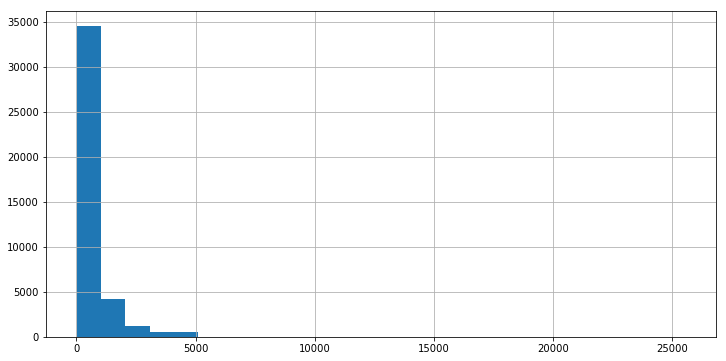

In [15]:
lens.hist(figsize=(12, 6), bins=25);

There are reviews with more than 5000 characters

In [16]:
long_reviews = train_df.loc[train_df['text'].str.len() > 5000].index

In [17]:
len(long_reviews)

20

In [18]:
train_df.drop(long_reviews, inplace=True)

In [19]:
lens = train_df['text'].str.len()
lens.mean(), lens.std(), lens.max()

(626.8270002938008, 759.5934657916472, 5000)

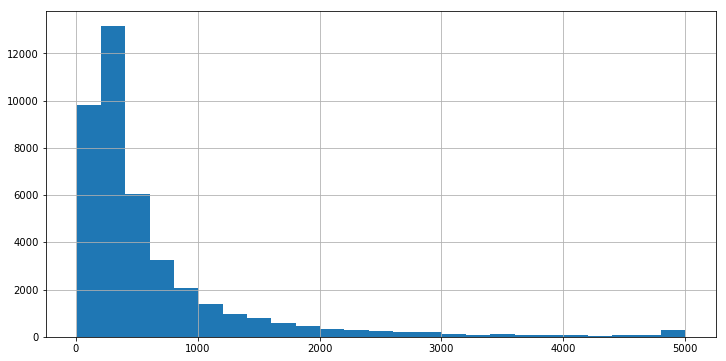

In [20]:
lens.hist(figsize=(12, 6), bins=25);

Split data into train and test set

In [21]:
X_train, X_test, y_train, y_test = train_test_split(train_df['text'].values, train_df['class'].values, test_size=0.2, random_state=42)

In [22]:
len(X_train), len(X_test), len(y_train), len(y_test)

(32675, 8169, 32675, 8169)

Defining tokenizer

In [23]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

Creating bag of words

In [24]:
vec = CountVectorizer(tokenizer=tokenize)

In [25]:
term_doc_train = vec.fit_transform(X_train)
term_doc_test = vec.transform(X_test)

Train term frequency contains 32675 documents and 45424 tokens. Each row represents a document and each column how many times that token appears on the document.

In [26]:
term_doc_train

<32675x45424 sparse matrix of type '<class 'numpy.int64'>'
	with 2564280 stored elements in Compressed Sparse Row format>

For instance, the first document have just 45 of the 45424 possible tokens. That's why the matrix is stored as a sparse matrix.

In [27]:
term_doc_train[0]

<1x45424 sparse matrix of type '<class 'numpy.int64'>'
	with 45 stored elements in Compressed Sparse Row format>

Get vocabulary

In [28]:
vocab = vec.get_feature_names()
len(vocab)

45424

In [29]:
vocab[4000: 4005]

['awaits', 'awake', 'awaken', 'awakened', 'awakening']

In [30]:
X_train[0]

'same ole same ole game, nothing new to see here.  maps still way to small, offers nothing new.  i think this franchise days are numbered!  couch zombie point and shot...yawn!  i have purchase all cod games, but never again.  graphics are upgraded on ps4, but series has become boring!'

First review's tokens

In [31]:
w0 = set([o for o in X_train[0].split(' ')])

In [32]:
w0

{'',
 'again.',
 'all',
 'and',
 'are',
 'become',
 'boring!',
 'but',
 'cod',
 'couch',
 'days',
 'franchise',
 'game,',
 'games,',
 'graphics',
 'has',
 'have',
 'here.',
 'i',
 'maps',
 'never',
 'new',
 'new.',
 'nothing',
 'numbered!',
 'offers',
 'ole',
 'on',
 'point',
 'ps4,',
 'purchase',
 'same',
 'see',
 'series',
 'shot...yawn!',
 'small,',
 'still',
 'think',
 'this',
 'to',
 'upgraded',
 'way',
 'zombie'}

In [33]:
vec.vocabulary_['think']

40189

In [34]:
term_doc_train[0, 40189]

1

### Naive Bayes

Here we reduce our training data to 2 dimentions (using TruncatedSVD rather than PCA because we are working with sparse matrices) and then we plot it in order to  roughly see how classes are separated

In [35]:
svd = TruncatedSVD()
red_term_doc_train = svd.fit_transform(term_doc_train)

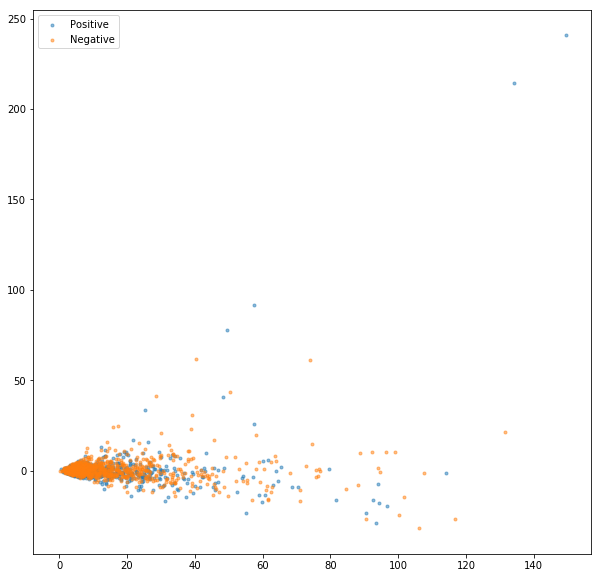

In [36]:
plot_embeddings(red_term_doc_train, y_train)

First attempt is to use a simple Naive Bayes

In [37]:
x = term_doc_train
y = y_train

p = x[y==1].sum(0) + 1
q = x[y==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [38]:
pre_preds = term_doc_test @ r.T + b
preds = pre_preds.T > 0
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9129636430407638


Rather than use r coefficients that we get trough Naive Bayes, let's learn them from data using Logistic Regression

In [39]:
m = LogisticRegression(C=0.25, dual=True)
m.fit(x, y)
preds = m.predict(term_doc_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.9362223038315584


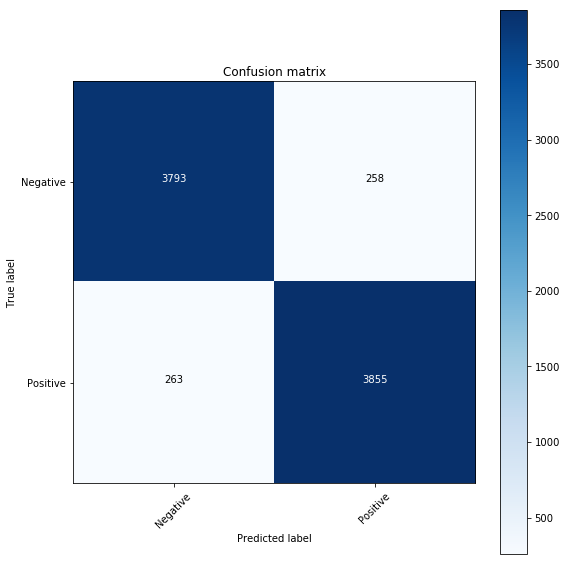

In [40]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

Let's plot most relevant words that the algorithm uses to classify a text in positive or negative

In [41]:
coef_df = pd.DataFrame({'vocab': vocab, 'coef':m.coef_.reshape(-1)})
pos_top10 = coef_df.sort_values('coef', ascending=False).reset_index(drop=True)[:10]
neg_top10 = coef_df.sort_values('coef').reset_index(drop=True)[:10]

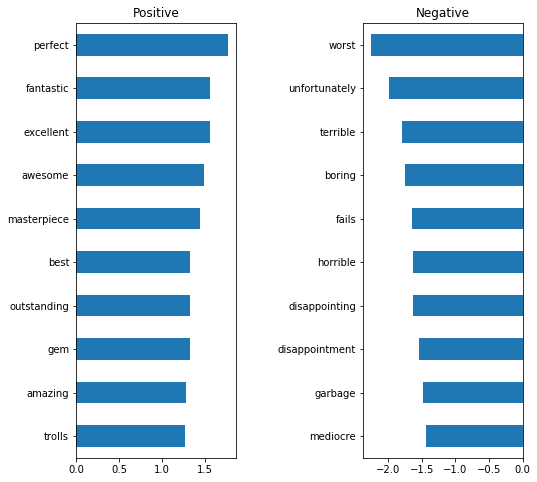

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(8, 8))
fig.subplots_adjust(wspace=0.8)
pos_top10.sort_values('coef').plot.barh(legend=False, ax=axs[0])
axs[0].set_yticklabels(pos_top10['vocab'].values.tolist()[::-1])
axs[0].set_title('Positive');
neg_top10.sort_values('coef', ascending=False).plot.barh(legend=False, ax=axs[1])
axs[1].set_yticklabels(neg_top10['vocab'].values.tolist()[::-1])
axs[1].set_title('Negative');

Let's try now with bigram tf-idf rather than unigram tf

In [43]:
vec = TfidfVectorizer(strip_accents='unicode', tokenizer=tokenize, ngram_range=(1, 2), max_df=0.9, min_df=3, sublinear_tf=True)

In [44]:
term_doc_train = vec.fit_transform(X_train)
term_doc_test = vec.transform(X_test)

Division between classes is more clear now

In [45]:
svd = TruncatedSVD()
red_term_doc_train = svd.fit_transform(term_doc_train)

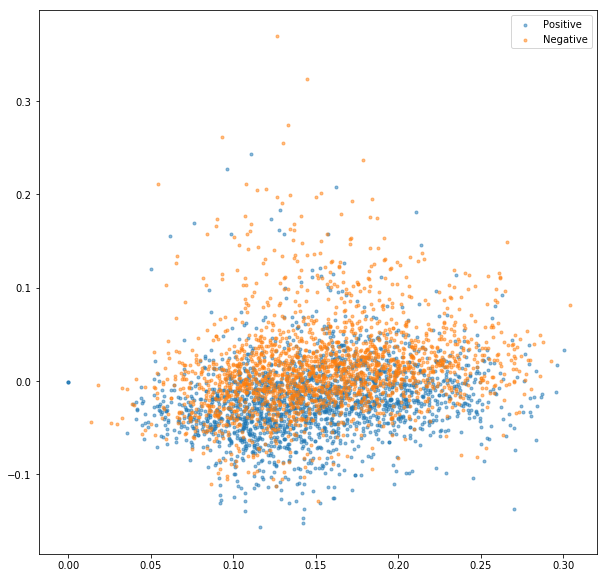

In [47]:
plot_embeddings(red_term_doc_train, y_train, 2000)

In [48]:
x = term_doc_train
y = y_train

p = x[y==1].sum(0) + 1
q = x[y==0].sum(0) + 1
r = np.log((p/p.sum())/(q/q.sum()))
b = np.log(len(p)/len(q))

In [49]:
m = LogisticRegression(C=20, dual=True)
m.fit(x, y)
preds = m.predict(term_doc_test)
acc = (preds==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.950055086301873


r coefficients from Naive Bayes are like a prior. With this slight difference in the code (x_nb = x.multiply(r)) we are saying to the regularization term that we want to penalize things that varies from our prior.

In [50]:
x_nb = x.multiply(r)
m = LogisticRegression(C=40, dual=True)
m.fit(x_nb, y)

x_nb_test = term_doc_test.multiply(r)
preds = m.predict(x_nb_test)
acc = (preds.T==y_test).mean()
print(f'Accuracy: {acc}')

Accuracy: 0.951768882360142


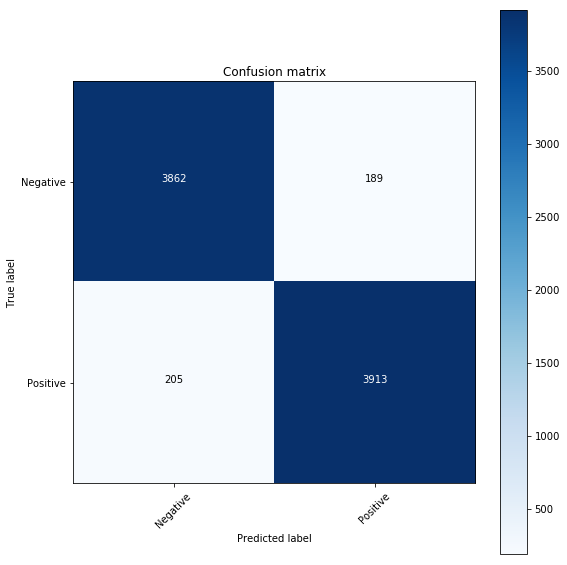

In [51]:
plot_confusion_matrix(confusion_matrix(y_test, preds.T), classes=['Negative', 'Positive'], title='Confusion matrix')

### CNN

In [52]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, concatenate
from keras.optimizers import Adam

/home/martinpella/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [53]:
train_df['tokenized'] = train_df['text'].apply(tokenize)

In [54]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [55]:
vocab_counter = collections.Counter()
train_df['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [56]:
len(vocab)

49796

In [57]:
w2id = {w:i for i, w in enumerate(vocab)}

In [58]:
def transform_to_ids(row):
    return [w2id[w] for w in row]

In [59]:
train_df['tokenized'] = train_df['tokenized'].apply(lambda x: transform_to_ids(x))

In [60]:
X_train, X_test, y_train, y_test = train_test_split(train_df['tokenized'].values, train_df['class'].values, test_size=0.2, random_state=42)

In [61]:
maxlen = 1000

In [62]:
x_train = pad_sequences(X_train, maxlen=maxlen, value=-1)
x_test = pad_sequences(X_test, maxlen=maxlen, value=-1)

In [143]:
model = Sequential([Embedding(input_dim=len(vocab), output_dim=32, input_length=maxlen),
                    SpatialDropout1D(0.2),
                    Dropout(0.4),
                    Convolution1D(64, 5, padding='same', activation='relu'),
                    Dropout(0.4),
                    MaxPooling1D(),
                    Flatten(),
                    Dense(100, activation='relu'),
                    Dropout(0.7),
                    Dense(1, activation='sigmoid')])

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [139]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=64)

Train on 32675 samples, validate on 8169 samples
Epoch 1/3
32675/32675 [==============================] - 8s - loss: 0.4064 - acc: 0.7875 - val_loss: 0.1865 - val_acc: 0.9322
Epoch 2/3
32675/32675 [==============================] - 8s - loss: 0.1636 - acc: 0.9426 - val_loss: 0.1553 - val_acc: 0.9425
Epoch 3/3
32675/32675 [==============================] - 8s - loss: 0.1134 - acc: 0.9612 - val_loss: 0.1542 - val_acc: 0.9445
